# The Kapitza Pendulum

### Physics 5300 Final Project AU25 - Neil Ghugare

The [Kapitza pendulum](https://en.wikipedia.org/wiki/Kapitza%27s_pendulum) is a rigid pendulum with a vertical-vibrating pivot point, nambed after Russian Nobel laureate Pyotr Kapitza, who developed a theory around the pendulum's propertieis in 1951 [1] [2]. 

## Table of Contents

- Chapter 0: Imports
- Chapter I: The Derivation
- Chapter II: Numerical Integration
- Chapter III: Exploration and Analysis
- Chapter IV: Manim Animations
- Chapter V: A Quick Examination of Chaos
- *(Appendix)* Chapter VI: Further Reading and Sources
- *(Appendix)*: Chapter VII: Addendum

## Chapter 0: Imports

In [1]:
# We use the widget package for nicer plot behavior.
%matplotlib widget 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from scipy.integrate import solve_ivp
from IPython.display import display, Image, Video
from base64 import b64encode

The following global boolean is defined if the animations should be remade. You can turn this to `False` if the animations are already present or to get the notebook to run faster for testing or changes. Otherwise, all animations will be remade when set to `True`.

In [3]:
animate = False

## Chapter I: The Derivation

This system is described by the following diagram:

<img src="kpdiagram.png" width="500px" />

For this system, with positive $x$ to the right and positive $y$ vertically up, we have the following system definitions,
* $\nu$: The so-called *driving frequency*, the frequency of the motor perturbing the lever arm vertically.
* $a$: The *driving amplitude*, the magnitude of the vertical oscillations of the lever arm.
* $l$: The *length* of the pendulum rod. 
* $m$: The *mass* of the pendulum bob.
* $\phi$: The *angle* of the pendulum with respect to the vertical, with $\phi=0$ being the bob straight down in $-y$.

We want to describe this system with the Lagrangian $\mathcal{L}$, given by
$$
\mathcal{L} = T-U,
$$
with potential energy $U$ and kinetic energy $T$. We first find the easier quantity, the potential energy. We define $U=0$ to be the horizontal line where $a=0$, with increasing energy upwards. We also assume, as indicated in the diagram, that the driving motor rotates clockwise. This means the potential energy is given by the gravitational potential energy due to the pendulum's position above the ground and the deviations in this height due to the driving motor, both impacting the gravitational potential energy. The height of the bob will be given by
$$
y_{\rm bob} = -l\cos{(\phi)},
$$
and the change in the driving amplitude $\Delta a$ is given by
$$
\Delta a = -a\cos{(\nu t)}.
$$
This has an implicit assumption that the motor is such that the driving amplitude $a$ is at minimum at $t=0$. Thus,
$$
U = mg(y_{\rm bob} + \Delta a) = -mg (l\cos{(\phi)} + a\cos{(\nu t)}).
$$

The kinetic energy is a tad more complicated. First, we ignore any resistance forces, like linear and higher-order drag, friction or heat from the motor, and any other non-ideal forces. The kinetic energy of the pendulum is the only thing we are concerned with, and it is given by
$$
T = \frac{1}{2} m (\dot{x}^2 + \dot{y}^2),
$$
in Cartesian coordinates. The $x$-direction velocity is simple, when expressed in terms of $\phi$ using polar coordinates,
$$
x = l\sin{(\phi)} \Rightarrow \dot{x}^2 = l^2\dot{\phi}^2\cos^2{(\phi)}.
$$
The $y$-direction has it's polar-coordinate counterpart, but also has the changes due to the change in driving amplitude:
$$
y = y_{\rm bob} + \Delta a = -(l\cos{(\phi)}+a\cos{(\nu t)}) \Rightarrow \dot{y}^2 = (l\dot{\phi}\sin{(\phi)}+a\nu\sin{(\nu t)})^2,
$$
or
$$
\dot{y}^2 = l^2\dot{\phi}^2\sin^2{(\phi)} + a^2\nu^2\sin^2{(\nu t)} + 2al\nu\dot{\phi}\sin{(\phi)}\sin{(\nu t)}.
$$
Thus,
$$
\dot{x}^2+\dot{y}^2 = l^2\dot{\phi}^2 + a^2\nu^2\sin^2{(\nu t)} + 2al\nu\dot{\phi}\sin{(\phi)}\sin{(\nu t)},
$$
and
$$
T = \frac{1}{2} m \left( l^2\dot{\phi}^2 + a^2\nu^2\sin^2{(\nu t)} + 2al\nu\dot{\phi}\sin{(\phi)}\sin{(\nu t)}\right).
$$

So, our Lagrangian is,
$$
\mathcal{L} = T-U = \frac{1}{2} m \left( l^2\dot{\phi}^2 + a^2\nu^2\sin^2{(\nu t)}+ 2al\nu\dot{\phi}\sin{(\phi)}\sin{(\nu t)}\right) +mg (l\cos{(\phi)}+a\cos{(\nu t)}).
$$

We can now recall the Euler-Lagrange equation and apply it to our one coordinate, $\phi$, 
$$
\frac{\partial \mathcal{L}}{\partial \phi} = \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{\phi}}.
$$

Before we go ahead and do this calculation, we can take advantage of some facts about the way the equation of motions come from the Euler-Lagrange equation. Based on the E-L equation, we can see by inspection that any terms that are constant, or any terms that only depend on time, will be "erased" from the equations of motion, so we can neglect them entirely. This includes the $a^2\nu^2\sin^2{(\nu t)}$ and the $a\cos{(\nu t)}$ term,
$$
\mathcal{L} = \frac{1}{2}ml^2\dot{\phi}^2 + mal\nu\dot{\phi}\sin{(\phi)}\sin{(\nu t)} + mgl\cos{(\phi)}.
$$

Now applying the E-L equation and taking the respective derivatives (and rearranging so $\ddot{\phi}$ is isolated and doing some cancellations), we get the equation of motion we wish to solve:
$$
\ddot{\phi} = - (g+a\nu^2 \cos{(\nu t)}) \frac{\sin{(\phi)}}{l}.
$$

We will numerically solve this equation of motion.

We also note a small assumption of our model. With the way we've set up our system in the diagram, we are assuming that the lever rod (the rod that moves the pendulum vertically) and the rod of the driving wheel that physically attenuates the lever rod both can stretch and compress without affecting the motion or dynamics of the system. If both rods were rigid, the pendulum would *not* have simple vertical oscillations, and would in fact sweep a circular arc, which we want to avoid. There are ways of creating diagrams of this system where this assumption is not needed, but given this is the prevalent style of diagram one finds (like on Wikipedia), we will continue with this diagram and assumption. This assumption, for reference, is called assuming *linear deflection*. We also assume no damping terms like air resistance.

## Chapter II: Numerical Integration

We import the class from the `PendulumSolver.py` file that will numerically solve this system. You can check out that file to learn more, but the help command on the file is provided for your inspection.

In [4]:
from PendulumSolver import KapitzaPendulum

help(KapitzaPendulum)

Help on class KapitzaPendulum in module PendulumSolver:

class KapitzaPendulum(builtins.object)
 |  KapitzaPendulum(m=1.0, l=1.0, g=1.0, a=1.0, nu=1.0)
 |
 |  Class that numerically solves the equations of motion for the Kapitza pendulum.
 |
 |  Methods defined here:
 |
 |  Liapunov_comparison(self, t_pts, phi_0, phi_dot_0, delta_phi=1e-06, delta_phi_dot=0.0)
 |      --- Description: ---
 |      Makes a comparsion relating to the Liapunov exponent, plotting log(|Delta phi|) vs. t.
 |
 |      --- Parameters (Required): ---
 |          1. t_pts - The finite array of time points to solve over.
 |          2. phi_pts - The phi points, phi(t).
 |          3. phi_dot_pts - The phi dot points, phi_dot(t).
 |
 |      --- Parameters (Optional): ---
 |          1. delta_phi - The (small) displacement between the two systems, for comparison.
 |          2. delta_phi_dot - The (small) velocity difference between the two systems, for comparison.
 |
 |      --- Returns: ---
 |          The matplotli

We do a quick check on the numerical solver using the `space_plots` function to plot the state space. We set up a known system, a simple pendulum (*without* the small angle approximation), which corresponds to $a=0$ and $\nu=0$. We see that the outputted state space plot with given initial conditions of $\phi_0=\pi/4$ and $\dot{\phi}_0=0$ gets us a familiar output.

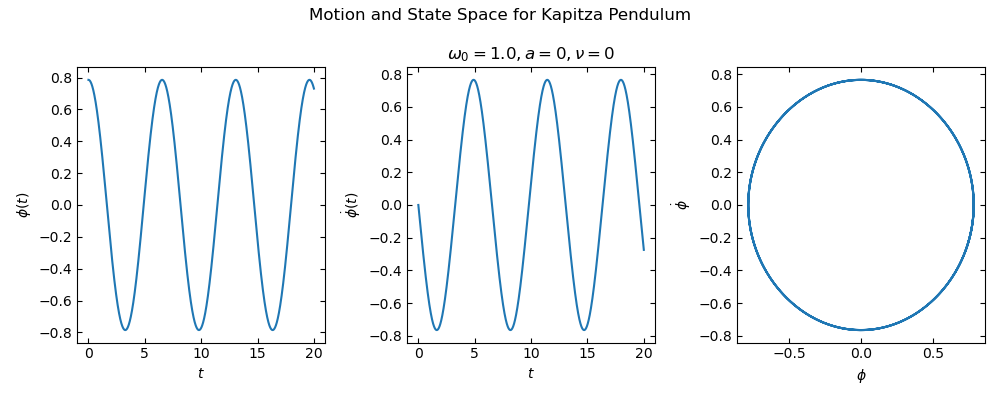

In [5]:
t_pts = np.arange(0., 20., 1e-3)

kp = KapitzaPendulum(a=0, nu=0)
phi, phi_dot = kp.solve_ode(t_pts, phi_0=np.pi/4, phi_dot_0=0.)

fig = kp.space_plots(t_pts, phi, phi_dot)
fig.savefig('SimplePendulumLimitingCase.png', dpi=300)

## Chapter III: Exploration and Analysis

For this analysis, we introduce a quantity that relates the driving amplitude $a$ to the length of the pendulum $l$. We call this parameter $\epsilon$, with
$$
\epsilon \equiv \frac{a}{l}.
$$

This helps us see how $a$ relates to $l$, relatively.

We will also introduce another relative parameter $f$, which relates the driving frequency $\nu$ to the natural frequency $\omega_0$. We define it as follows,
$$
f \equiv \frac{\nu}{\omega_0}.
$$

This means for our analysis, we will have three free parameters: $\omega_0$ will define the relation between $g$ and $l$, $f$ will define the relation between $\nu$ and $\omega_0$, and $\epsilon$ will define the relation between $a$ and $l$. For our purposes, we will use $g=1$ for our numerical solutions below. We won't necessarily use it, but we can rewrite our equation of motion to be:
$$
\ddot{\phi} = - \omega_0^2(1+\epsilon f^2 \cos{(f \omega_0 t)})\sin{(\phi)}.
$$

In fact, we will mostly use $l=g=1$ (ignoring units), such that $\omega_0^2$ equals 1. That is recommended for the widget too, as then you can explore how $f$ and $\epsilon$ directly change the system, as that would make $\nu$ and $a$ direct scalings of $\omega_0$ and $l$. 

In [6]:
m = 1  # Not really important, it's not used in the equations of motion.
l = 1  
g = 1  # Implies that omega0 is 1.

t_pts = np.arange(0., 20., 1e-3)

Below is documented code that will make the widget,

Output()

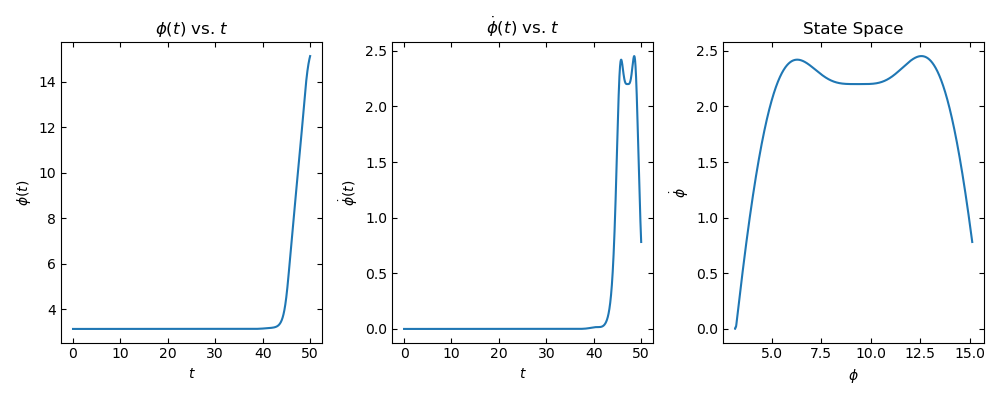

In [7]:
# Setup the figure with three separate mutable axes.
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# A function that sets up the figure for the widget 
def setup_figure():
    """
    --- Description: ---
    Sets up the figure for the widget for the Kapitza system.

    --- Parameters (Required): ---
        None

    --- Parameters (Optional): ---
        None

    --- Returns: ---
        None
    """
    # Set the title and labels for the first axis.
    ax1.set_title(r'$\phi(t)$ vs. $t$')
    ax1.set_xlabel(r'$t$')
    ax1.set_ylabel(r'$\phi(t)$')
    ax1.tick_params(axis='both', top=True, right=True, which='both', direction='in')

    # Likewise for the second axis.
    ax2.set_title(r'$\dot{\phi}(t)$ vs. $t$')
    ax2.set_xlabel(r'$t$')
    ax2.set_ylabel(r'$\dot{\phi}(t)$')
    ax2.tick_params(axis='both', top=True, right=True, which='both', direction='in')

    # Likewise for the third axis.
    ax3.set_title(r'State Space')
    ax3.set_xlabel(r'$\phi$')
    ax3.set_ylabel(r'$\dot{\phi}$')
    ax3.tick_params(axis='both', top=True, right=True, which='both', direction='in')

    # Tight layout of the figure.
    fig.tight_layout()

# Make plots for given values
def make_plots(omega0, epsilon, f, phi0, phi_dot0, t_max, ax1_passed, ax2_passed, ax3_passed):
    """
    --- Description: ---
    Make plots for given values of a Kapitza system.

    --- Parameters (Required): ---
        1. omega0 - The natural frequency of the system.
        2. epsilon - The relation between driving amplitude and pendulum length.
        3. f - The relation between driving frequency and natural frequency.
        4. phi0 - The initial phi position.
        5. phi_dot0 - The initial phi velocity.
        6. ax1_passed - The passed-in mutable first axis object.
        7. ax2_passed - The passed-in mutable second axis object.
        8. ax3_passed - The passed-in mutable third axis object.

    --- Parameters (Optional): ---
        None

    --- Returns: ---
        None
    """
    # Reset the graph.
    reset_graph(None)

    # Calculate some constant values like pendulum length, derived from given parameters.
    l = 1/np.sqrt(omega0)
    a = l*epsilon
    nu = f*omega0

    t_pts = np.arange(0., t_max, 1e-3)

    # Solve the system.
    kp = KapitzaPendulum(m=1, l=l, g=1, a=a, nu=nu)
    phi, phidot = kp.solve_ode(t_pts, phi0, phi_dot0)

    # Plot the differing axis plots, like phi vs. t.
    ax1_passed.plot(t_pts, phi)
    ax2_passed.plot(t_pts, phidot)
    ax3_passed.plot(phi, phidot)

    # Tight layout of the fig.
    fig.tight_layout()

# Reset the graph
def reset_graph(event):
    """
    --- Description: ---
    Reset the widget plots.

    --- Parameters (Required): ---
        1. event - The reset event, you can ignore this.

    --- Parameters (Optional): ---
        None

    --- Returns: ---
        None
    """
    # Clear all the axes.
    ax1.clear()
    ax2.clear()
    ax3.clear()

    # Set up the figure again.
    setup_figure()

# Button on the widget to reset the figure.
button = widgets.Button(description='Clear Graph')
button.on_click(reset_graph)

style = {'description_width': 'initial'}

# Sliders for omega0, epsilon, f, and more.
omega0 = widgets.FloatSlider(min=0.1, max=10., step=.05, value=1., description=r'$\omega_0$', continuous_update=False, style=style)
epsilon = widgets.FloatSlider(min=0., max=10., step=.05, value=1., description=r'$\epsilon$', continuous_update=False, style=style)
f = widgets.FloatSlider(min=0., max=50., step=.05, value=1., description=r'$f$', continuous_update=False, style=style)
phi0 = widgets.FloatSlider(min=-np.pi, max=np.pi, step=.05, value=np.pi, description=r'$\phi_0$', continuous_update=False, style=style)
phi_dot0 = widgets.FloatSlider(min=0., max=10., step=.05, value=0., description=r'$\dot{\phi}_0$', continuous_update=False, style=style)
t_max = widgets.FloatSlider(min=10., max=100., step=1., value=50., description=r'$t_{\rm max}$', continuous_update=False, style=style)

# Group inline (e.g. 2 rows of sliders) using VBox.
ui = widgets.VBox([
    widgets.HBox([omega0, epsilon, f]),
    widgets.HBox([phi0, phi_dot0, t_max, button])
])

# Make the interactive widget and display it.
out = widgets.interactive_output(
    make_plots, 
    {
        'omega0': omega0,
        'epsilon': epsilon,
        'f': f,
        'phi0': phi0,
        'phi_dot0': phi_dot0,
        't_max': t_max,
        'ax1_passed': widgets.fixed(ax1),
        'ax2_passed': widgets.fixed(ax2),
        'ax3_passed': widgets.fixed(ax3)
    }
)
display(ui, out)

# Setup the figure.
setup_figure()

For our exploration, we mainly want to look into when the vertical position of the pendulum, $\phi=\pi$ is stable. By this, we mean that oscillations happen around the top and is stable in its oscillations. Through our own inspection and intuition, we find many cases where the stability is *temporary*, especially for the resonance ($\nu\approx\omega_0$) regime and the simple ($\nu=a=0$) regime. These do not tend to stay forever stable. Whether this is a true result or numerical artifact is hard to decouple in these cases. However, there is one regime where the oscillate is definitely stable, and that's the high driving ($\nu>>\omega_0$) and low amplitude ($a<<l$) regime. We plot snapshots of $U(\phi, t)$ here, but it's not inherently obvious that a system like this is stable. So, we will do some math and use $U_{\rm eff}(\phi, t)$.

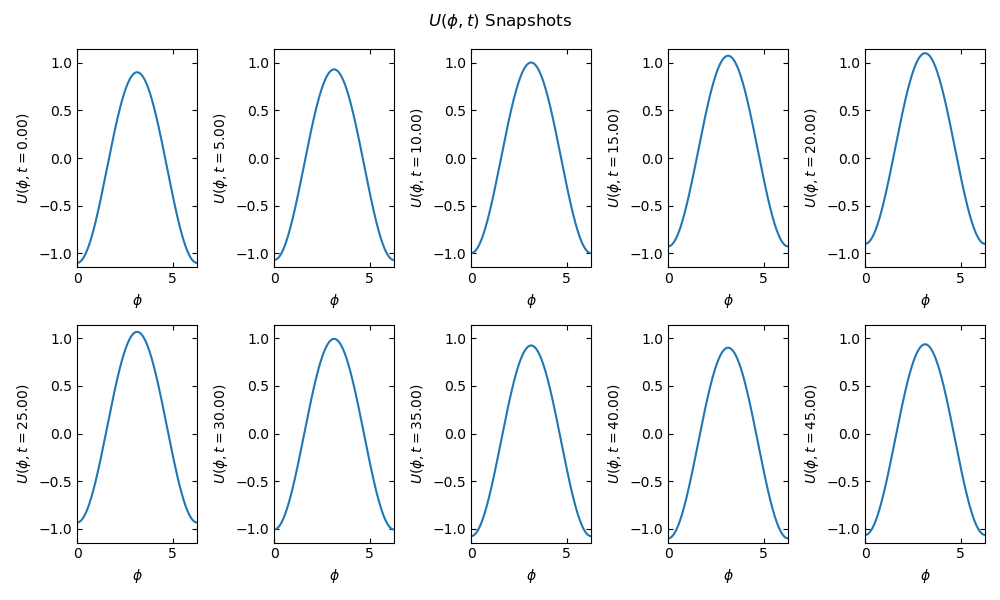

In [8]:
kp = KapitzaPendulum(m=1.0, l=1.0, g=1.0, a=0.1, nu=30.0)
fig = kp.U_snapshots()
fig.savefig('USnapshots.png', dpi=300)

Our true $U$ is
$$
U = U(\phi, t) = -mg (l\cos{(\phi)} + a\cos{(\nu t)}).
$$
From a slow-fast decomposition of the motion for this regime (see the `SlowFastDecomposition.pdf` file for a more-rigorous derivation), we see that
$$
U_{\rm eff}(\phi) \approx -mgl\cos{(\phi)} + \frac{ma\nu^2}{4l} \sin^2{(\phi)},
$$
which we will use going forward.

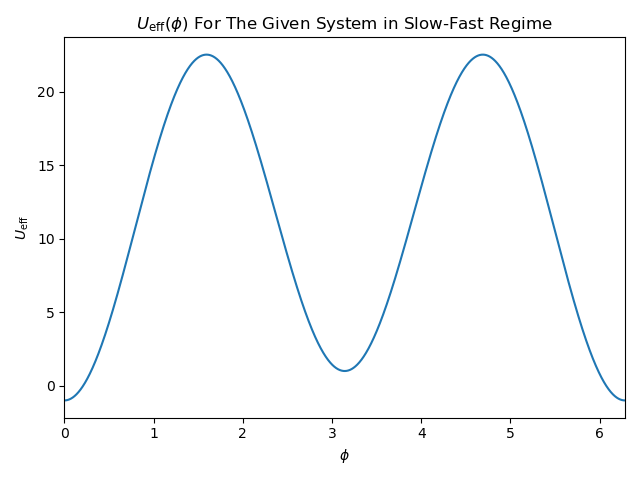

In [9]:
phi_pts = np.arange(0.0, 2*np.pi + 1e-3, 1e-3)
fig = kp.U_eff_plot(phi_pts)
fig.savefig('UeffPlot.png', dpi=300)

## Chapter IV: Manim Animations

We can make Manim animations of this system. We have implemented this in the `ManimAnimation.py` file. We import the animation, held in the `KapitzaPendulumAnimation` class, and the helpful dataclass `PendulumParams` (which allows us to update the parameters for the animation in code itself). We will use Jupyter cell magic to animate.

In [10]:
from ManimAnimation import KapitzaPendulumAnimation, PendulumParams

Here is some more info on the `PendulumParams` class:

In [11]:
help(PendulumParams)

Help on class PendulumParams in module ManimAnimation:

class PendulumParams(builtins.object)
 |  PendulumParams(m: float = 1.0, l: float = 1.0, g: float = 1.0, a: float = 1.0, nu: float = 1.0, phi_0: float = 1.5707963267948966, phi_dot_0: float = 0.0, t_max: float = 30.0) -> None
 |
 |  Stores parameters used for the dictionary
 |
 |  Methods defined here:
 |
 |  __delattr__(self, name)
 |      Implement delattr(self, name).
 |
 |  __eq__(self, other)
 |      Return self==value.
 |
 |  __hash__(self)
 |      Return hash(self).
 |
 |  __init__(self, m: float = 1.0, l: float = 1.0, g: float = 1.0, a: float = 1.0, nu: float = 1.0, phi_0: float = 1.5707963267948966, phi_dot_0: float = 0.0, t_max: float = 30.0) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __setattr__(self, name, value)
 |      Implement setattr(self, name, value).
 |
 |  ----------------------------------------------------------------

Below is an example of a Kapitza system. We plot the solved state space plot below to see we are getting the same results. We will do more examination of stable and unstable solutions through the Hopf bifurcation in the next section on *chaos*.

In [12]:
params = PendulumParams()
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumAnimation.params = params

# Use --fps 120 to double frame rate
if animate:
    %manim -qm -v WARNING -o one.mp4 KapitzaPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/one.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=1.0, nu=1.0, phi_0=1.5707963267948966, phi_dot_0=0.0, t_max=30.0)


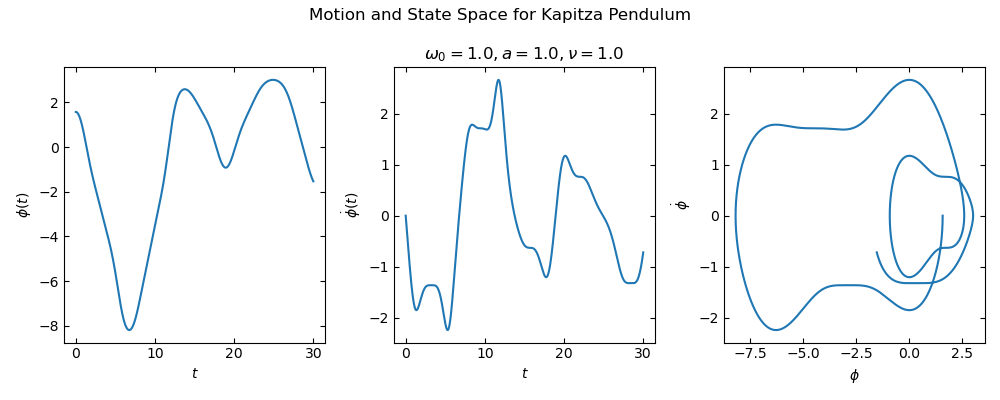

In [13]:
t_pts = np.arange(0., 30., 1e-3)

kp = KapitzaPendulum()
phi, phi_dot = kp.solve_ode(t_pts, phi_0=np.pi/2, phi_dot_0=0.)

fig = kp.space_plots(t_pts, phi, phi_dot)

There are example systems held in the `ExampleSystems.py` file that can be animated directly, with set parameters.

## Chapter V: A Quick Examination of Chaos

This is the main section of this notebook. We will now examine stable and unstable solutions of the *vertical position* ($\phi=\pi$) through analysis of chaos through the [Liapunov exponent](https://en.wikipedia.org/wiki/Lyapunov_exponent) and the [Hopf bifurcation](https://en.wikipedia.org/wiki/Hopf_bifurcation) [6] [7].

The Liapunov exponent helps us measure whether a system exhibits chaos with extremely small changes in the system's initial conditions. With a positive Liapunov exponent, we expect chaos, otherwise we don't. Plots of this behavior, customizable, can be found in the `Liapunov_comparison` function. We can see that the following system exhibits chaos:

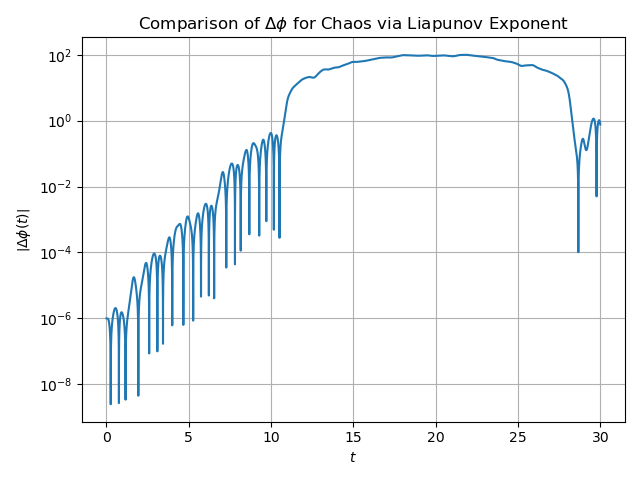

In [14]:
kp = KapitzaPendulum(a=6.85, nu=4.)
t_pts = np.arange(0., 30., 1e-3)

fig = kp.Liapunov_comparison(t_pts, phi_0=np.pi/2, phi_dot_0=0.0, delta_phi=1.0e-6)

We can see that this plot of $|\Delta \phi(t)|$ vs. $t$, which defines the Liapunov exponent, is largely positive, so we expect chaos for this system. The exponent starts leveling off due to the systemic barrier of the system (the difference between the two compared systems can only really be so far apart, since they are fixed to rotate in a closed system, and are not unbounded). 

The following system doesn't, since it has little driving amplitude and frequency, and has a low starting $\phi_0$.

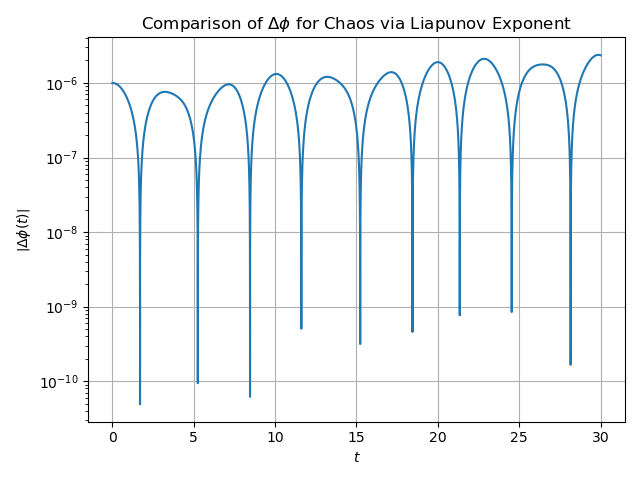

In [15]:
kp = KapitzaPendulum(a=0.1, nu=2.5)
t_pts = np.arange(0., 30., 1e-3)

fig = kp.Liapunov_comparison(t_pts, phi_0=0.86, phi_dot_0=0.0, delta_phi=1.0e-6)

Although this exponent seems positive, remembering the log-scale, this would mean an extremely tiny Liapunov exponent, which we can generally discount. 

Now we will make animations to examine the chaotic natures of these two systems to ensure these results are sensible. These animations are also stored in the `ManimAnimation.py` file under the class `KapitzaPendulumChaosAnimation`. It also uses `PendulumParams`.

In [16]:
from ManimAnimation import KapitzaPendulumChaosAnimation

We first animate the expected chaotic system, and see we do indeed get some chaotic motion (note the scaling of the shown Liapunov plot).

This example in `ExampleSystems.py` is `ExampleLiapunovChaosSystem`.

In [17]:
params = PendulumParams(a=6.85, nu=4., phi_0=np.pi/2, phi_dot_0=0.0)
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumChaosAnimation.params = params

if animate:
    %manim -qm -v WARNING -o two.mp4 KapitzaChaosPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/two.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=6.85, nu=4.0, phi_0=1.5707963267948966, phi_dot_0=0.0, t_max=30.0)


For the non-chaotic system, we see what we expect, no chaos.

This example in `ExampleSystems.py` is `ExampleNonChaosSystem`.

In [18]:
params = PendulumParams(a=0.1, nu=2.5, phi_0=0.86, phi_dot_0=0.0)
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumChaosAnimation.params = params

if animate:
    %manim -qm -v WARNING -o three.mp4 KapitzaChaosPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/three.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=0.1, nu=2.5, phi_0=0.86, phi_dot_0=0.0, t_max=30.0)


Now we're going to examine for a fixed driving frequency $\nu$, and increasing driving amplitude $a$, the Hopf bifurcation of the stability of the vertical equilibrium at $\phi=\pi$. For our purposes, we chose $\nu=30$. This first plot is for increasing driving amplitude from 0 to 0.5. The dots on the graph are the Poincaré plots at the periods of the *driving frequency*. We have a rough model of the Hopf bifurcation visible from the distribution of the Poincaré plots. This is an intensive process, so we've already made the plots and simply display them. In this first plot, we see a very large bifurcation window of stability. Note that the two lines are present, but equal (stability at $\phi=\pi$ or $\phi=-\pi$ are equivalent). We see another smaller bifurcation later, which we shall examine later.

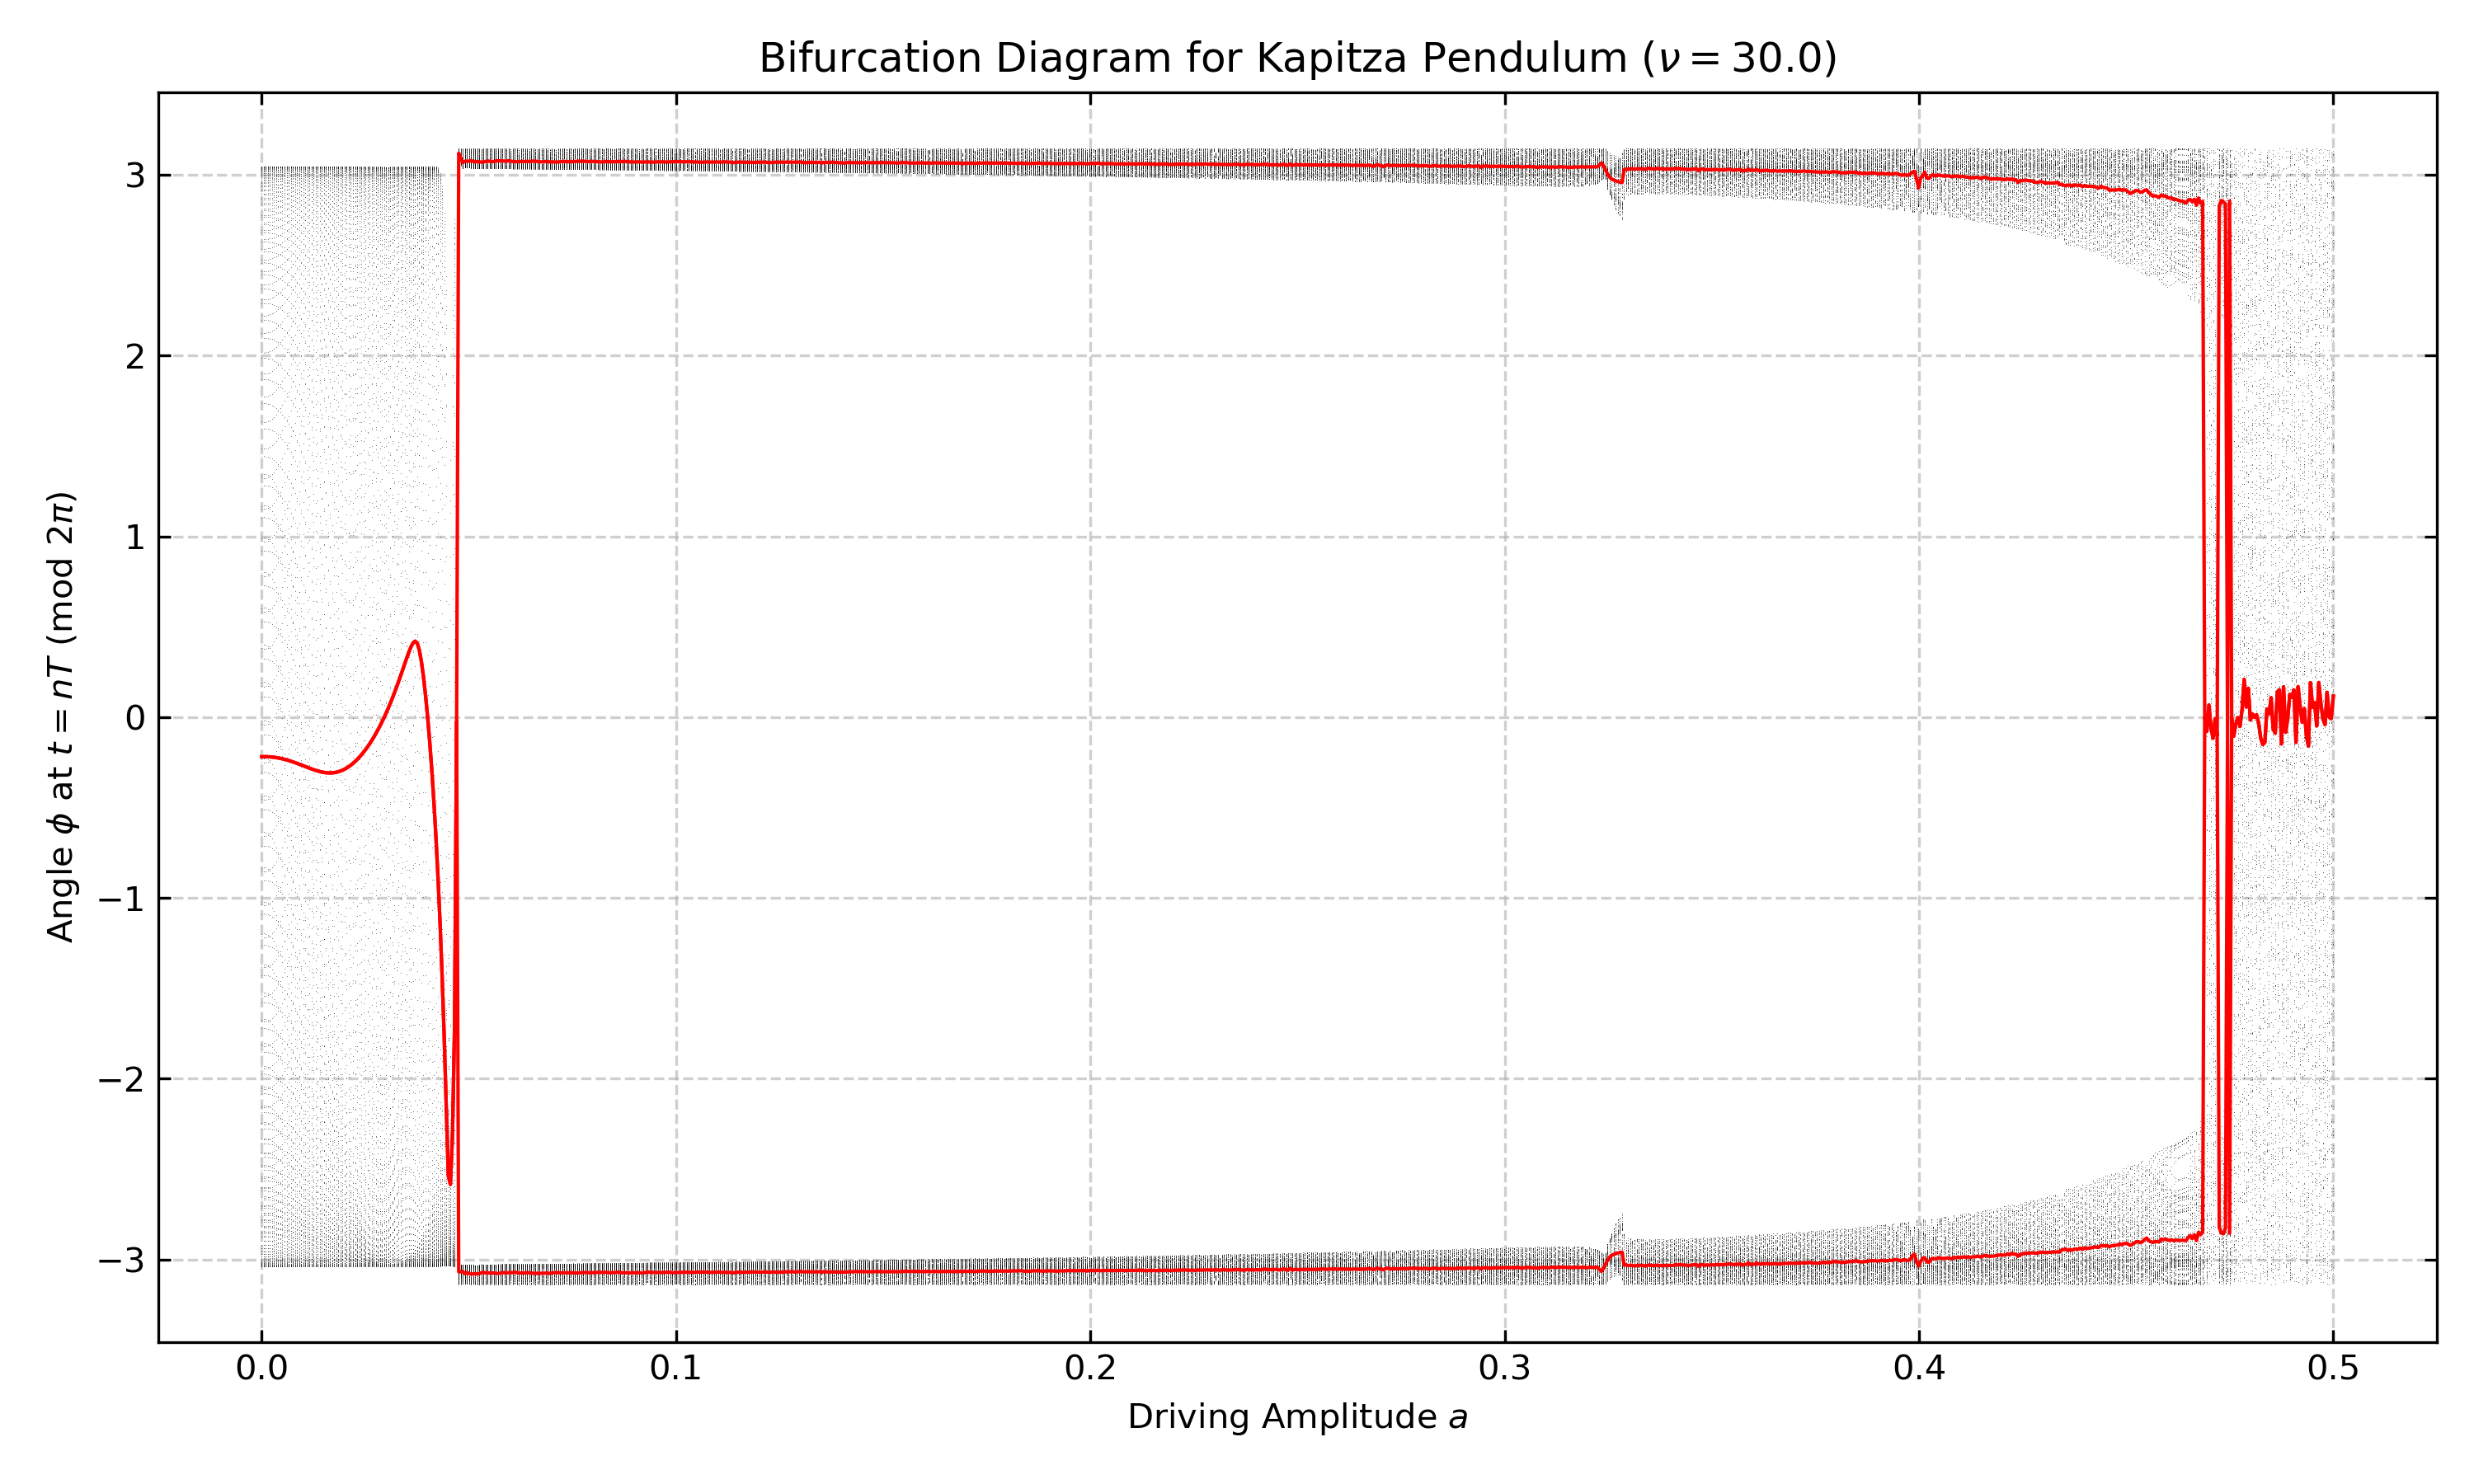

In [19]:
kp = KapitzaPendulum(a=0.1, nu=30.0)
t_pts = np.arange(0., 30., 1e-3)

# This is an intensive process so we just read and show the earlier created image.
# fig = kp.bifurcation(phi_0=np.pi-0.1, phi_dot_0=0.0, a_range=(0.0, 0.5, 1000))
# fig.savefig('BifurcationDiagram.png', dpi=300)
# plt.close()

Image(filename='BifurcationDiagram.png')  # Display the last saved image.

From this plot, we can infer that a system starting in the vertical position with no initial velocity should be stable at $\nu=30$ for $a=0.25$, let's say. Likewise, for $a=0.5$, this should be clearly chaotic. Let's use our animations to check this. These example systems are `ExampleHopfNonChaosSystem` and `ExampleHopfChaosSystem`, respectively.

In [20]:
params = PendulumParams(a=0.25, nu=30.0, phi_0=np.pi-0.1, phi_dot_0=0.0)
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumChaosAnimation.params = params

if animate:
    %manim -qm -v WARNING -o four.mp4 KapitzaChaosPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/four.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=0.25, nu=30.0, phi_0=3.041592653589793, phi_dot_0=0.0, t_max=30.0)


In [21]:
params = PendulumParams(a=0.5, nu=30.0, phi_0=np.pi-0.1, phi_dot_0=0.0)
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumChaosAnimation.params = params

if animate:
    %manim -qm -v WARNING -o five.mp4 KapitzaChaosPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/five.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=0.5, nu=30.0, phi_0=3.041592653589793, phi_dot_0=0.0, t_max=30.0)


We see that this inference holds, which is good. To show some more bifurcation details, we will numerically "zoom in" on those smaller bifurcations that appear later, from $a=0.45$ to $a=0.5$, again just displaying the output due to the computational intensity of this process.

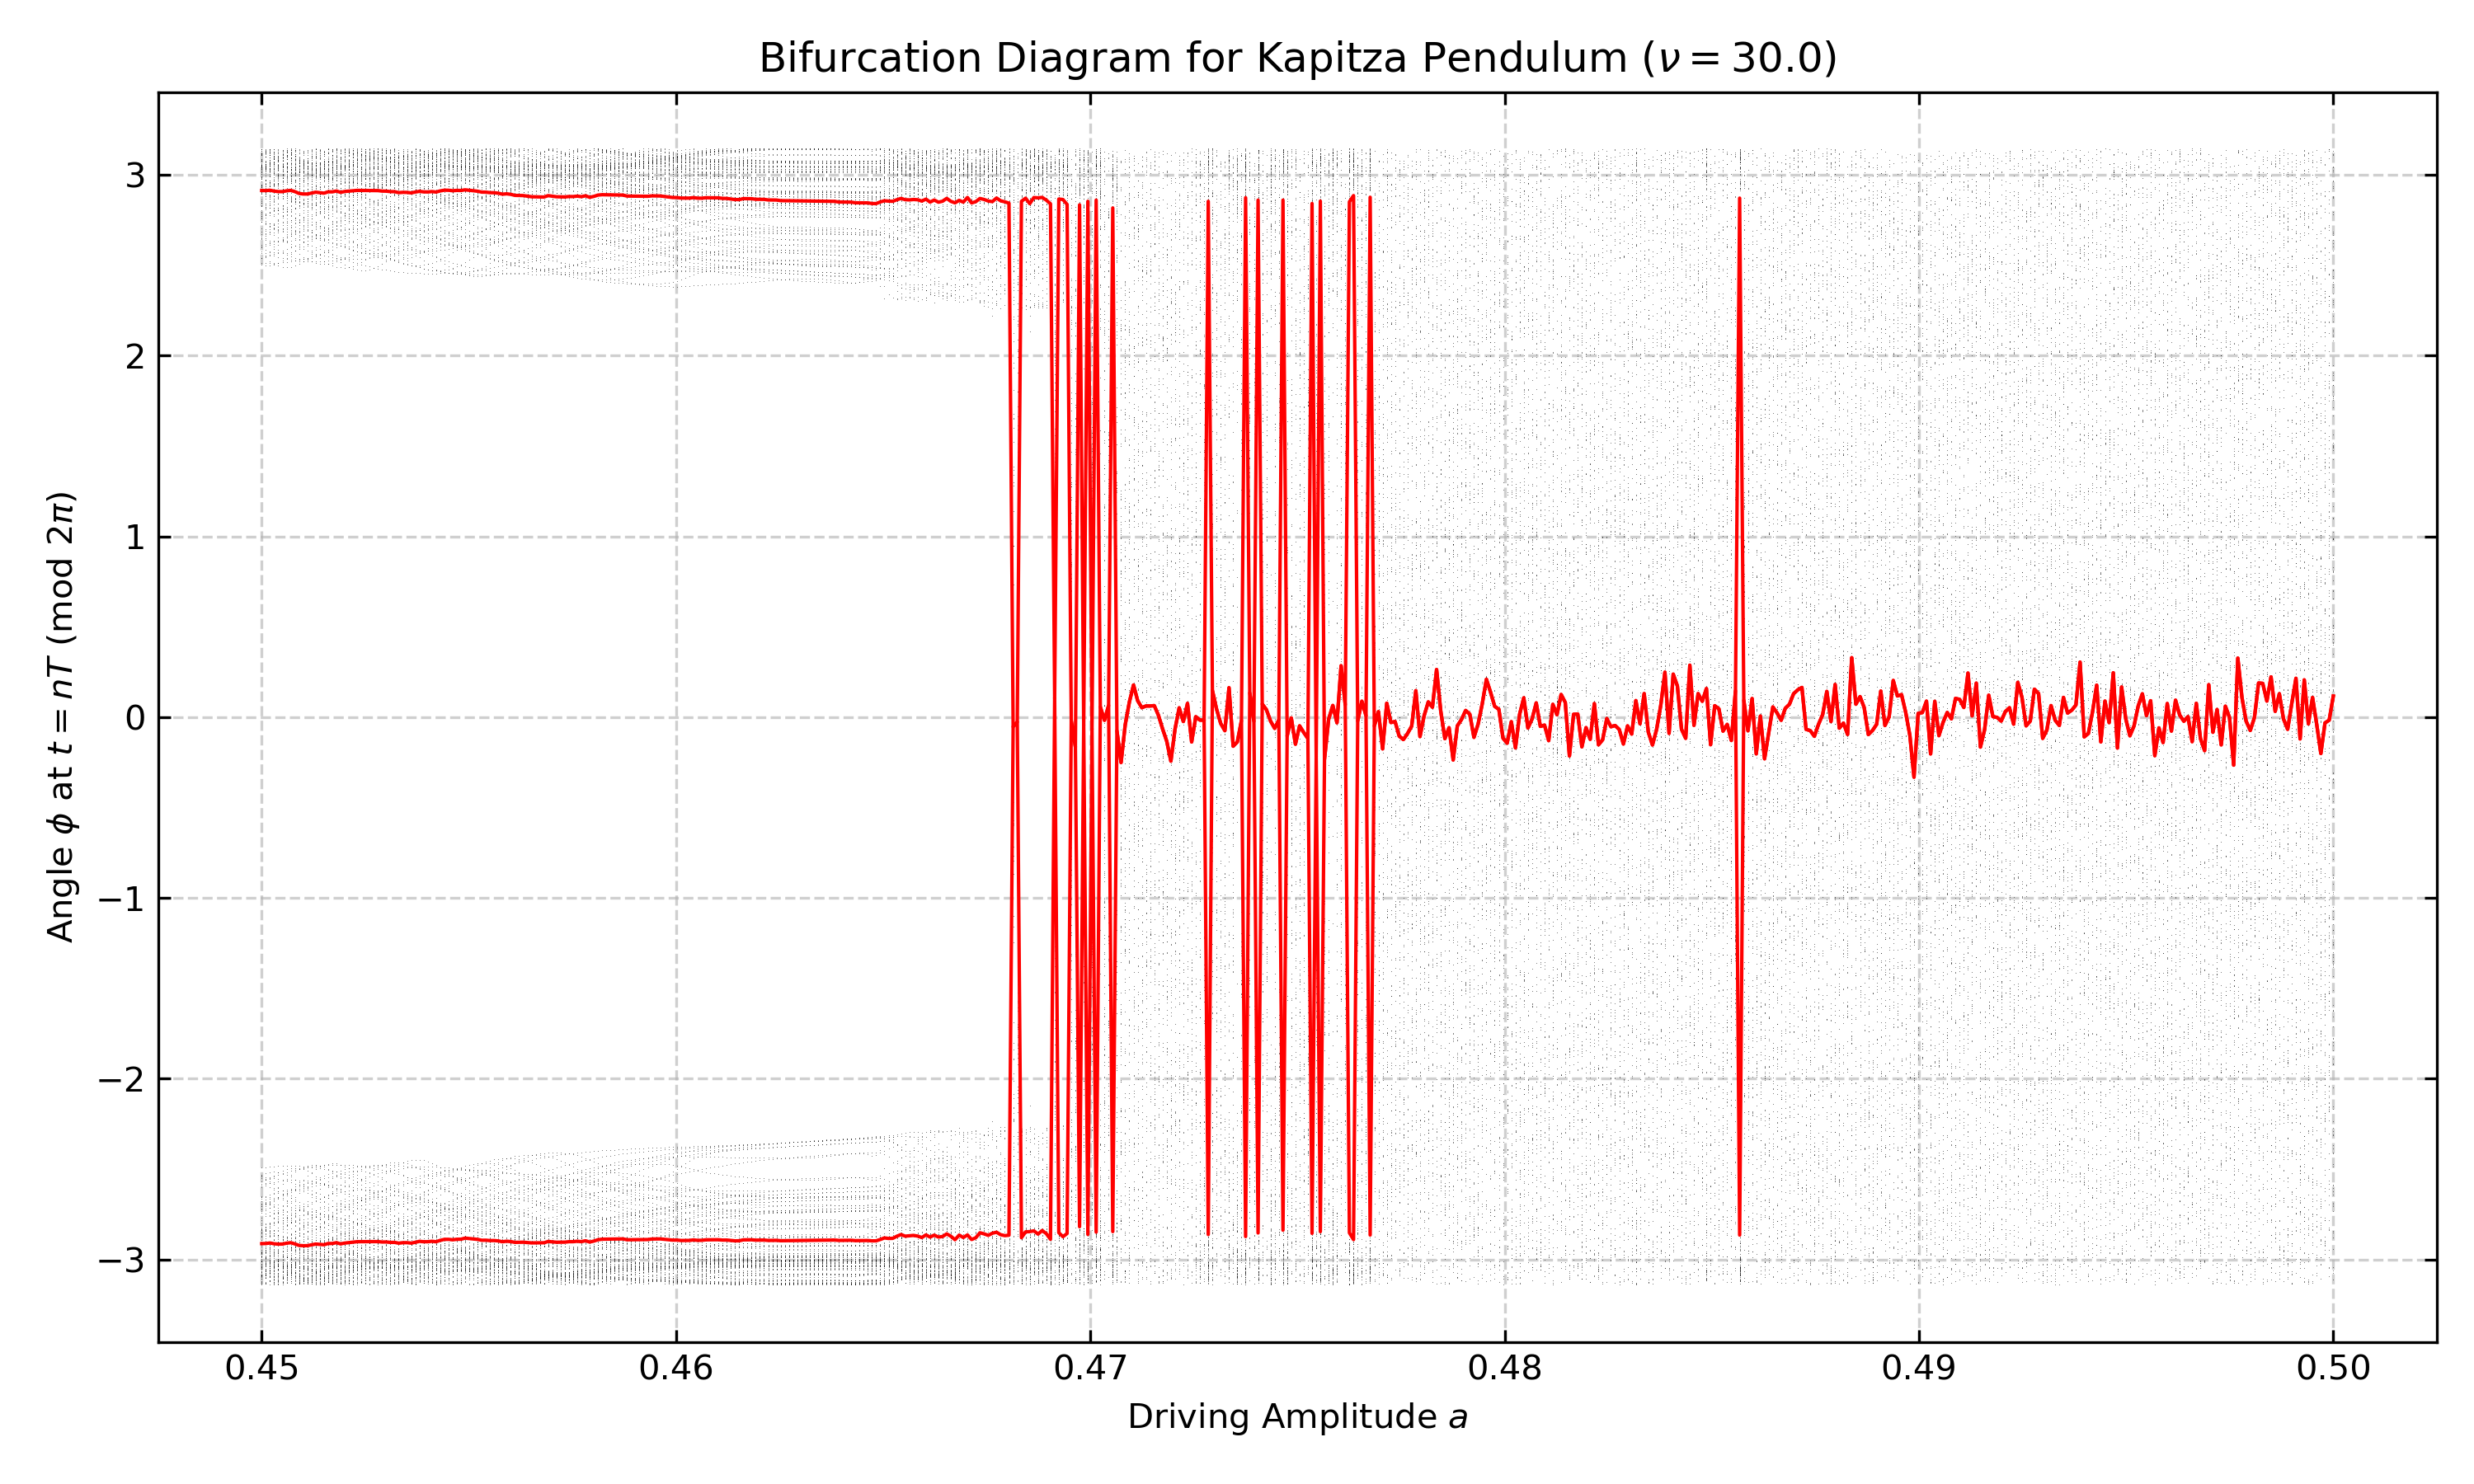

In [22]:
# This is an intensive process so we just read and show the earlier created image.
# fig = kp.bifurcation(phi_0=np.pi-0.1, phi_dot_0=0.0, a_range=(0.45, 0.5, 500))
# fig.savefig('BifurcationDiagram_2.png', dpi=300)
# plt.close()

Image(filename='BifurcationDiagram_2.png')  # Display the last saved image.

From this, we can see many more bifurcations, with more (smaller) ranges of stability, as the amplitude increases.

To add some insight and for completeness, for $a$ really small, we see "chaos", but it's important to distinguish this. With (effectively) no driving amplitude, the driving frequency is useless, and thus, the system is not really chaotic, but is undergoing slow motions around the top (due to starting close to $\phi=\pi$ and gravitational effects), while still in simple pendulum motion. So, for Poincaré points of the driving frequency, we don't necessarily get the anticipated period-doubling motion, which is why we see this "chaotic" display. It is important to separate this in our inference of these plts. In this style of system, the equilibrium itself $\phi=\pi$ is not even reached in the expected period, showing the inaccesibility of the $\phi=\pi$ point being stable. This is also due to us numerically solving with $\phi_0$ being slightly less than $\pi$.

In [23]:
params = PendulumParams(a=0.0, nu=30.0, phi_0=np.pi-0.1, phi_dot_0=0.0)
print(params)  # Debugging check, ensure the right parameters are being used 

KapitzaPendulumChaosAnimation.params = params

if animate:
    %manim -qm -v WARNING -o six.mp4 KapitzaChaosPendulumAnimation
else:
    try:
        display(Video('./media/videos/src/720p30/six.mp4', embed=True, width=700))
    except:
        print('Video error... skipping...')

PendulumParams(m=1.0, l=1.0, g=1.0, a=0.0, nu=30.0, phi_0=3.041592653589793, phi_dot_0=0.0, t_max=30.0)


From this animation, we see at the top of the motion, many Poincaré points will be plotted, due to the many rotations of the driving frequency. However, points will also be plotted in the pendulum swing. However these points do nothing to explain the motion, as this animation has $a=0$, so that is why we brought up this distinction.

## Chapter VI *(Appendix)*: Further Reading and Sources

[[1]](https://en.wikipedia.org/wiki/Kapitza's_pendulum) Kapitza Pendulum, Wikipedia <br>
[[2]](https://ufn.ru/ufn51/ufn51_5/Russian/r515_b.pdf) Kapitza *Soviet Phys. JETP* (1951) -- *In Russian*<br>
[[3]](https://link.springer.com/content/pdf/10.1007/BF01013307.pdf) McLaughlin *J. Stat. Phys.* (1980) <br>
[[4]](https://www.sciencedirect.com/science/article/pii/0375960183903365?via%3Dihub) Koch et al. *Phys. Lett. A* (1983) <br>
[[5]](https://pubs.aip.org/aapt/ajp/article-abstract/60/10/903/1054037/Stability-and-Hopf-bifurcations-in-an-inverted?redirectedFrom=fulltext) Blackburn et al. *Am. J. Phys.* (1992) <br>
[[6]](https://en.wikipedia.org/wiki/Lyapunov_exponent) Liapunov Exponent, Wikipedia <br>
[[7]](https://en.wikipedia.org/wiki/Hopf_bifurcation) Hopf Bifurcation, Wikipedia <br>

## Chapter VII *(Appendix)*: Addendum

There exists in the `PendulumSolver.py` file a subclass called `DampedKapitzaPendulum`, which is the same as the Kapitza system we solve, but allows for a damping parameter $\gamma$, such that
$$
\ddot{\phi} = - (g+a\nu^2 \cos{(\nu t)}) \frac{\sin{(\phi)}}{l} - \gamma \dot{\phi}.
$$

There are many more aspects of the Kapitza pendulum that we have not explored here. This includes *rotating solutions*, where the system rotates exactly at the driving frequency $\nu$. We also did not investigate further in *chaos and bifurcations*, and more options for strange-behavior systems outside of the $\phi=\pi$ position. As implicitly stated above, we did not investigate *damping* of any kind. Finally, we did not do any Hamiltonian or phase-space investigations, which have been shown to yield helpful and interesting results for analyzing this system. These should all be topics of interest for extensions on this work. For more brief (although someone unhelpful) information on these aspects, see the [Wikipedia page](https://en.wikipedia.org/wiki/Kapitza%27s_pendulum#Phase_portrait) [1]. 